In [29]:
import os
import random
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
import spacy
from spacy.tokenizer import Tokenizer
import gensim

import torch
import torch.nn as nn

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [33]:
train = pd.read_csv('../train_tweet.csv')
test = pd.read_csv('../test_tweets.csv')
print("TRAIN")
print(train.shape)
print(train.info())
print("\n=====================================\n")
print("TEST")
print(test.shape)
print(test.info())

TRAIN
(31962, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB
None


TEST
(17197, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      17197 non-null  int64 
 1   tweet   17197 non-null  object
dtypes: int64(1), object(1)
memory usage: 268.8+ KB
None


In [34]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [35]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [36]:
print("TRAIN SAMPLES")
for i in range(10):
  print(train['tweet'][i])
  print("------------------")
print("\n=====================================\n")
print("TEST SAMPLES")
for i in range(10):
  print(test['tweet'][i])
  print("------------------")

TRAIN SAMPLES
 @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
------------------
@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked
------------------
  bihday your majesty
------------------
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦  
------------------
 factsguide: society now    #motivation
------------------
[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo  
------------------
 @user camping tomorrow @user @user @user @user @user @user @user dannyâ¦
------------------
the next school year is the year for exams.ð¯ can't think about that ð­ #school #exams   #hate #imagine #actorslife #revolutionschool #girl
------------------
we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â¦ 
------------------
 @user @user wel

In [37]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', 
          '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', '·', '_', 
          '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×',
          '§', '″', '′', 'Â', '█', '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', 
          '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', 
          '‹', '─', '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 
          'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', 
          '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 
          'Ø', '¹', '≤', '‡', '√', '#', '¦']


def clean_text(x):
    x = str(x)
    for punct in puncts:
        x = x.replace(punct, '')
    return x


# def clean_numbers(x):
#     x = re.sub('[0-9]{5, }', '#####', x)
#     x = re.sub('[0-9]{4}', '####', x)
#     x = re.sub('[0-9]{3}', '###', x)
#     x = re.sub('[0-9]{2}', '##', x)
#     return x

In [38]:
mispell_dict = {"aren't": "are not", "can't": "cannot", 
                "couldn't": "could not", "didn't": "did not",
                "doesn't": "does not", "don't": "do not", 
                "hadn't": "had not", "hasn't": "has not",
                "haven't": "have not", "he'd": "he would", 
                "he'll": "he will", "he's": "he is",
                "i'd": "I would", "i'd": "I had", "i'll": 
                "I will", "i'm" : "I am", "isn't": "is not",
                "it's": "it is", "it'll": "it will", 
                "i've" : "I have", "let's": "let us", 
                "mightn't": "might not", "mustn't": "must not", 
                "shan't" : "shall not", "she'd": "she would",
                "she'll": "she will", "she's": "she is", 
                "shouldn't": "should not", "that's": "that is", 
                "there's": "there is","they'd": "they would", 
                "they'll": "they will", "they're": "they are",
                "they've": "they have", "we'd": "we would", 
                "we're": "we are", "weren't": "were not",
                "we've": "we have", "what'll": "what will", 
                "what're": "what are", "what's": "what is", 
                "what've": "what have", "where's": "where is", 
                "who'd": "who would", "who'll": "who will",
                "who're": "who are", "who's": "who is", 
                "who've": "who have", "won't": "will not",
                "wouldn't" : "would not", "you'd": "you would", 
                "you'll": "you will", "you're": "you are",
                "you've": "you have", "'re": " are", 
                "wasn't": "was not", "we'll": " will", 
                "didn't": "did not", "tryin'": "trying", 
                "colour": "color", "centre": "center",
                "didnt": "did not", "doesnt": "does not",
                "isnt": "is not", "shouldnt": "should not",
                "favourite": "favorite", "travelling": "traveling",
                "counselling": "counseling", "theatre": "theater",
                "cancelled": "canceled", "labour": "labor",
                "organisation": "organization", "wwii": "world war 2",
                "citicise": "criticize", "instagram": "social medium",
                "whatsapp": "social medium", "snapchat": "social medium"}


def get_mispell(mispell_dict):
    mispell_re = re.compile('(%s)' % '|'.join(mispell_dict.keys()))
    return mispell_dict, mispell_re


def replace_typical_misspell(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace, text)

In [39]:
mispellings, mispellings_re = get_mispell(mispell_dict)
mispellings, mispellings_re

({"'re": ' are',
  "aren't": 'are not',
  "can't": 'cannot',
  'cancelled': 'canceled',
  'centre': 'center',
  'citicise': 'criticize',
  'colour': 'color',
  "couldn't": 'could not',
  'counselling': 'counseling',
  "didn't": 'did not',
  'didnt': 'did not',
  "doesn't": 'does not',
  'doesnt': 'does not',
  "don't": 'do not',
  'favourite': 'favorite',
  "hadn't": 'had not',
  "hasn't": 'has not',
  "haven't": 'have not',
  "he'd": 'he would',
  "he'll": 'he will',
  "he's": 'he is',
  "i'd": 'I had',
  "i'll": 'I will',
  "i'm": 'I am',
  "i've": 'I have',
  'instagram': 'social medium',
  "isn't": 'is not',
  'isnt': 'is not',
  "it'll": 'it will',
  "it's": 'it is',
  'labour': 'labor',
  "let's": 'let us',
  "mightn't": 'might not',
  "mustn't": 'must not',
  'organisation': 'organization',
  "shan't": 'shall not',
  "she'd": 'she would',
  "she'll": 'she will',
  "she's": 'she is',
  "shouldn't": 'should not',
  'shouldnt': 'should not',
  'snapchat': 'social medium',
  "that's

In [40]:
train['tweet'] = train['tweet'].apply(lambda x: replace_typical_misspell(x.lower()))
test['tweet'] = test['tweet'].apply(lambda x: replace_typical_misspell(x.lower()))

train['tweet'] = train['tweet'].apply(lambda x: clean_text(x.lower()))
test['tweet'] = test['tweet'].apply(lambda x: clean_text(x.lower()))

In [41]:
print("TRAIN SAMPLES")
for i in range(10):
  print(train['tweet'][i])
  print("------------------")
print("\n=====================================\n")
print("TEST SAMPLES")
for i in range(10):
  print(test['tweet'][i])
  print("------------------")

TRAIN SAMPLES
 user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction   run
------------------
user user thanks for lyft credit i cannot use cause they do not offer wheelchair vans in pdx    disapointed getthanked
------------------
  bihday your majesty
------------------
model   i love u take with u all the time in urð ððððððð  
------------------
 factsguide society now    motivation
------------------
22 huge fan fare and big talking before they leave chaos and pay disputes when they get there allshowandnogo  
------------------
 user camping tomorrow user user user user user user user danny
------------------
the next school year is the year for examsð cannot think about that ð­ school exams   hate imagine actorslife revolutionschool girl
------------------
we won love the land allin cavs champions cleveland clevelandcavaliers   
------------------
 user user welcome here   i am   it is so gr8  
------------------


T

In [42]:
def remove_emoji(sentence):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', sentence)

def remove_stopwords(sentence):
    words = sentence.split()
    words = [word for word in words if word not in stopwords.words('english')]
    
    return ' '.join(words)

In [43]:
stemmer = SnowballStemmer('english')
wl = WordNetLemmatizer()
def lemmatize_words(sentence):
    words = sentence.split()
    words = [wl.lemmatize(word) for word in words]
    return ' '.join(words)

In [44]:
# Clear emojis
train["tweet"] = train["tweet"].apply(lambda x: remove_emoji(x))
test["tweet"] = test["tweet"].apply(lambda x: remove_emoji(x))

# Stopwords
train["tweet"] = train["tweet"].apply(lambda x: remove_stopwords(x))
test["tweet"] = test["tweet"].apply(lambda x: remove_stopwords(x))

# Lemmatization
train["tweet"] = train["tweet"].apply(lambda x: lemmatize_words(x))
test["tweet"] = test["tweet"].apply(lambda x: lemmatize_words(x))

In [45]:
print("TRAIN SAMPLES")
for i in range(10):
  print(train['tweet'][i])
  print("------------------")
print("\n=====================================\n")
print("TEST SAMPLES")
for i in range(10):
  print(test['tweet'][i])
  print("------------------")

TRAIN SAMPLES
user father dysfunctional selfish drag kid dysfunction run
------------------
user user thanks lyft credit cannot use cause offer wheelchair van pdx disapointed getthanked
------------------
bihday majesty
------------------
model love u take u time urð ðððð ððð
------------------
factsguide society motivation
------------------
22 huge fan fare big talking leave chaos pay dispute get allshowandnogo
------------------
user camping tomorrow user user user user user user user danny
------------------
next school year year examsð cannot think ð­ school exam hate imagine actorslife revolutionschool girl
------------------
love land allin cavs champion cleveland clevelandcavaliers 
------------------
user user welcome gr8
------------------


TEST SAMPLES
studiolife aislife requires passion dedication willpower find newmaterials
------------------
user white supremacist want everyone see new  birds movie  heres
------------------
safe way heal

Text(0.5, 1.0, 'Distribution of tweet length in characters')

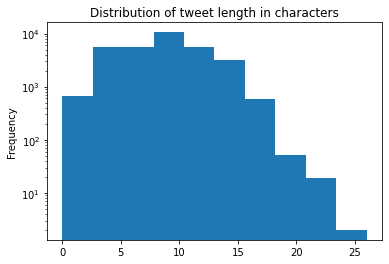

In [46]:
train['tweet'].apply(lambda x: len(x.split())).plot(kind='hist')
plt.yscale('log')
plt.title('Distribution of tweet length in characters')

In [48]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-04-12 16:23:25--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-12 16:23:25--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-12 16:23:25--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [49]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [50]:
!ls

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
glove.6B.200d.txt  glove.6B.50d.txt   sample_data


In [56]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    # print(word)
    # print(values)
    coefs = np.asarray(values[1:], dtype='float32')
    # print(coefs)
    embeddings_index[word] = coefs
f.close()

print('Found', len(embeddings_index), 'word vectors.')

Indexing word vectors.
Found 400000 word vectors.
